# Boosting Models — Vehicle Loan Default (XGBoost / LightGBM / CatBoost)

This notebook trains several gradient-boosted tree models on the **same processed dataset** and **same split mapping** used elsewhere in the project:

- Processed features: `data/processed/loan_processed.csv`
- Split mapping (by `UNIQUEID`): `data/splits/split_uniqueid.csv`

It exports **test-split** predictions to `results/` in the same schema used by the model comparison notebook:

- `UNIQUEID`, `y_true`, `y_prob`


## 1) Imports + Configuration

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay, confusion_matrix,
    brier_score_loss, average_precision_score,
    roc_auc_score, log_loss

)
from sklearn.calibration import calibration_curve

warnings.filterwarnings("ignore")

# Shared artifacts created by notebooks/01_preprocessing.ipynb
DATA_PATH = os.path.join('..', 'data', 'processed', 'loan_processed.csv')
SPLIT_PATH = os.path.join('..', 'data', 'splits', 'split_uniqueid.csv')

RESULTS_DIR = os.path.join('..', 'results')
MODELS_DIR = os.path.join('..', 'models')
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

RANDOM_STATE = 42
id_col = "UNIQUEID"
target_col = "LOAN_DEFAULT"

print("DATA_PATH:", DATA_PATH)
print("SPLIT_PATH:", SPLIT_PATH)
print("RESULTS_DIR:", RESULTS_DIR)


DATA_PATH: ..\data\processed\loan_processed.csv
SPLIT_PATH: ..\data\splits\split_uniqueid.csv
RESULTS_DIR: ..\results


## 2) Load processed dataset

In [2]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Missing {DATA_PATH}. Run notebooks/01_preprocessing.ipynb to generate data/processed/loan_processed.csv"
    )

df = pd.read_csv(DATA_PATH)
print("Loaded processed CSV:", df.shape)
display(df.head())

missing = [c for c in [id_col, target_col] if c not in df.columns]
if missing:
    raise ValueError(f"Processed CSV missing required columns: {missing}")

print("Target distribution:")
display(df[target_col].value_counts(dropna=False))
display(df[target_col].value_counts(normalize=True, dropna=False))


Loaded processed CSV: (233154, 40)


,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,...,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,AVERAGE_ACCT_AGE_MONTHS,CREDIT_HISTORY_LENGTH_MONTHS,AGE_AT_DISBURSAL_DAYS
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,0,0,0,0,0,0,0,0,0,12633
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,0,1991,0,0,1,0,1,23,23,12110
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,0,0,0,0,0,0,0,0,0,12030
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,0,31,0,0,0,1,1,8,15,9066
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,0,0,0,0,0,1,1,0,0,14901


Target distribution:


LOAN_DEFAULT
0    182543
1     50611
Name: count, dtype: int64

LOAN_DEFAULT
0    0.782929
1    0.217071
Name: proportion, dtype: float64

## 3) Create/load the shared split mapping (train/val/test by `UNIQUEID`)

We reuse the same idea as the NN notebook: the provided `test.csv` is unlabeled, so we carve out a **labeled holdout** from the training population using `split_uniqueid.csv`.

In [3]:
def make_or_load_split_ids(df_raw: pd.DataFrame, path: str, seed: int = 42,
                           test_size: float = 0.15, val_size: float = 0.15) -> pd.DataFrame:
    if os.path.exists(path):
        split_ids = pd.read_csv(path)
        if id_col not in split_ids.columns or "split" not in split_ids.columns:
            raise ValueError(f"{path} must contain columns: [{id_col}, 'split']")
        return split_ids[[id_col, "split"]]

    rng = np.random.default_rng(seed)
    n = len(df_raw)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_test = int(round(n * test_size))
    n_val = int(round(n * val_size))

    test_idx = idx[:n_test]
    val_idx = idx[n_test:n_test + n_val]
    train_idx = idx[n_test + n_val:]

    split = pd.DataFrame({id_col: df_raw[id_col].values, "split": "train"})
    split.loc[val_idx, "split"] = "val"
    split.loc[test_idx, "split"] = "test"

    os.makedirs(os.path.dirname(path), exist_ok=True)
    split[[id_col, "split"]].to_csv(path, index=False)
    return split[[id_col, "split"]]

split_ids = make_or_load_split_ids(df, SPLIT_PATH, seed=RANDOM_STATE)
display(split_ids["split"].value_counts())
display(split_ids.head())


split
train    163207
test      34974
val       34973
Name: count, dtype: int64

,UNIQUEID,split
0,420825,val
1,537409,val
2,417566,val
3,624493,train
4,539055,train


## 4) Build train/val/test frames

In [4]:
dfm = df.merge(split_ids, on=id_col, how="inner")

train_df = dfm[dfm["split"] == "train"].copy()
val_df   = dfm[dfm["split"] == "val"].copy()
test_df  = dfm[dfm["split"] == "test"].copy()

print("train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)


train: (163207, 41) val: (34973, 41) test: (34974, 41)


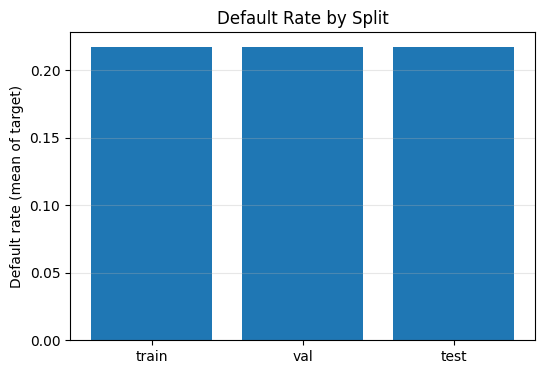

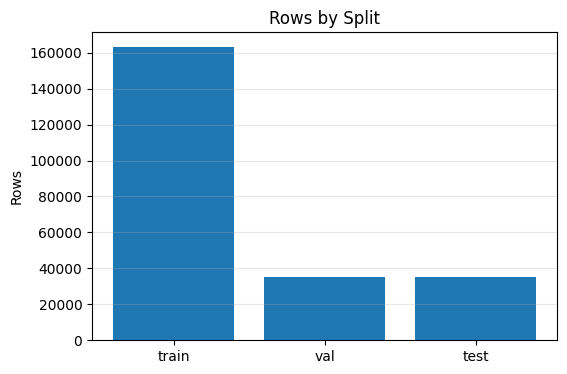

In [5]:
def plot_split_target_rates(train_df, val_df, test_df, target_col="LOAN_DEFAULT"):
    splits = {"train": train_df, "val": val_df, "test": test_df}
    rates = {k: v[target_col].mean() for k, v in splits.items()}
    counts = {k: len(v) for k, v in splits.items()}

    plt.figure(figsize=(6,4))
    plt.bar(list(rates.keys()), list(rates.values()))
    plt.ylabel("Default rate (mean of target)")
    plt.title("Default Rate by Split")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.bar(list(counts.keys()), list(counts.values()))
    plt.ylabel("Rows")
    plt.title("Rows by Split")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

plot_split_target_rates(train_df, val_df, test_df, target_col=target_col)

## 5) Feature columns + preprocessing

The processed dataset is mostly numeric, but we keep a robust preprocessing pipeline:
- numeric: median impute
- categorical: most-frequent impute + one-hot

This pipeline will be used for **XGBoost** and **LightGBM**. For **CatBoost**, we train directly on pandas with native categorical handling.

In [6]:
feature_cols = [c for c in df.columns if c not in [id_col, target_col]]
X_train_raw, y_train = train_df[feature_cols], train_df[target_col].astype(int).values
X_val_raw,   y_val   = val_df[feature_cols],   val_df[target_col].astype(int).values
X_test_raw,  y_test  = test_df[feature_cols],  test_df[target_col].astype(int).values

cat_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in feature_cols if c not in cat_cols]

print("n_features:", len(feature_cols))
print("num_cols:", len(num_cols), "cat_cols:", len(cat_cols))
print("cat_cols:", cat_cols)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
)

# Fit preprocessing ON TRAIN only
X_train = preprocess.fit_transform(X_train_raw)
X_val   = preprocess.transform(X_val_raw)
X_test  = preprocess.transform(X_test_raw)

print("Transformed shapes:", X_train.shape, X_val.shape, X_test.shape)


n_features: 38
num_cols: 36 cat_cols: 2
cat_cols: ['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION']
Transformed shapes: (163207, 58) (34973, 58) (34974, 58)


## 6) Helper utilities (evaluation + export)

In [7]:
def evaluate_binary(y_true: np.ndarray, y_prob: np.ndarray, name: str = "model") -> dict:
    out = {
        "model": name,
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "log_loss": float(log_loss(y_true, y_prob)),
    }
    return out

def export_predictions(unique_ids: pd.Series, y_true: np.ndarray, y_prob: np.ndarray, out_path: str):
    out = pd.DataFrame({
        id_col: unique_ids.values,
        "y_true": y_true.astype(int),
        "y_prob": y_prob.astype(float),
    })
    out.to_csv(out_path, index=False)
    print("Saved:", out_path, "shape:", out.shape)
    display(out.head())


## 7) XGBoost

XGBoost is a gradient boosting framework optimized for speed and regularization. It is well suited for structured tabular data and often serves as a strong baseline in credit risk problems.

In [8]:
val_probs = {}
test_probs = {}

In [12]:
import xgboost as xgb
from scipy import sparse

feature_names = preprocess.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feature_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feature_names)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.03,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "min_child_weight": 1.0,
    "seed": RANDOM_STATE,
}

evals = [(dtrain, "train"), (dval, "val")]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=200,
)

print("Best iteration:", bst.best_iteration)

[0]	train-logloss:0.52235	val-logloss:0.52238
[200]	train-logloss:0.48938	val-logloss:0.49719
[400]	train-logloss:0.48219	val-logloss:0.49527
[600]	train-logloss:0.47653	val-logloss:0.49437
[800]	train-logloss:0.47148	val-logloss:0.49409
[1000]	train-logloss:0.46681	val-logloss:0.49393
[1158]	train-logloss:0.46329	val-logloss:0.49393
Best iteration: 958


In [13]:
p_val  = bst.predict(dval)
p_test = bst.predict(dtest)
val_probs["XGBoost"] = p_val
test_probs["XGBoost"] = p_test

display(evaluate_binary(y_val, p_val, "xgboost_native_es"))

out_path = os.path.join(RESULTS_DIR, "boosting_xgb_test_preds.csv")
export_predictions(test_df[id_col], y_test, p_test, out_path)

model_path = os.path.join(MODELS_DIR, "xgb_model.json")
bst.save_model(model_path)
print("Saved model to:", model_path)

{'model': 'xgboost_native_es',
 'roc_auc': 0.6640726343200074,
 'pr_auc': 0.34619815847593066,
 'log_loss': 0.493931040717195}

Saved: ..\results\boosting_xgb_test_preds.csv shape: (34974, 3)


,UNIQUEID,y_true,y_prob
0,490213,0,0.312877
1,492995,1,0.516769
2,586411,0,0.236244
3,519075,0,0.168035
4,525983,0,0.103246


Saved model to: ..\models\xgb_model.json


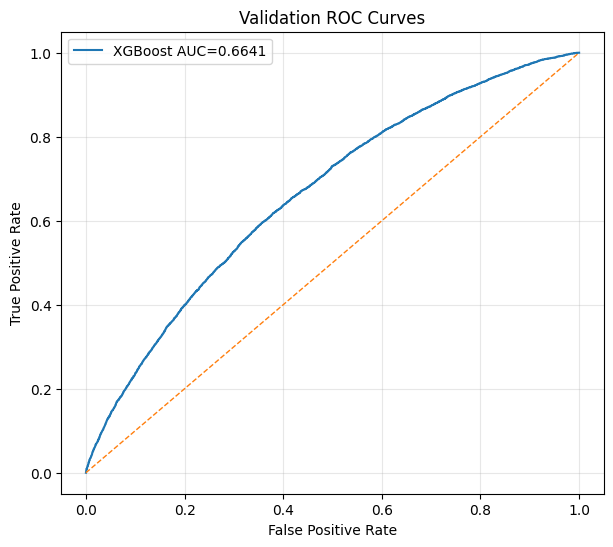

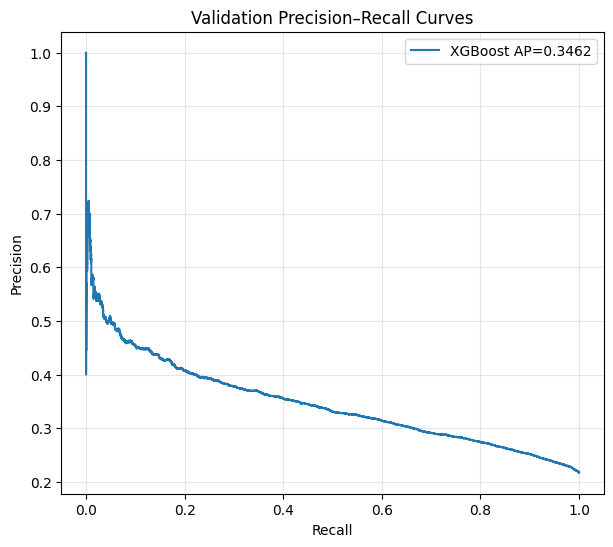

In [14]:
def plot_roc_pr(y_true, prob_dict, title_prefix="Validation"):
    # ROC
    plt.figure(figsize=(7,6))
    for name, p in prob_dict.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} AUC={auc:.4f}")
    plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # PR
    plt.figure(figsize=(7,6))
    for name, p in prob_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, p)
        ap = average_precision_score(y_true, p)
        plt.plot(rec, prec, label=f"{name} AP={ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision–Recall Curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_pr(y_val, val_probs, title_prefix="Validation")

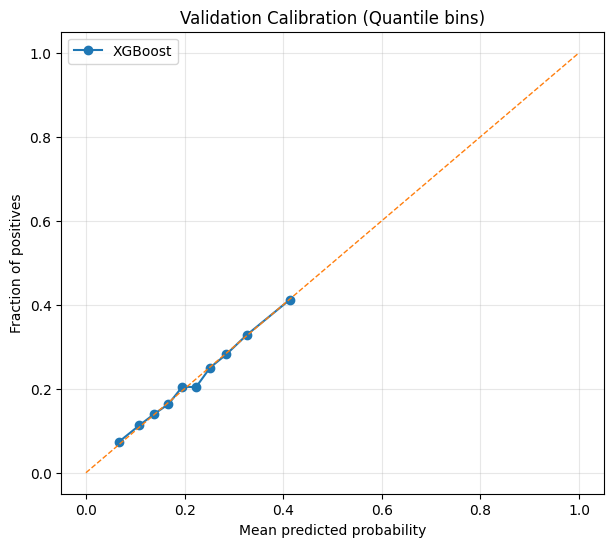

,brier_score
XGBoost,0.160043


In [15]:
def plot_calibration(y_true, prob_dict, n_bins=10, title="Validation Calibration"):
    plt.figure(figsize=(7,6))
    for name, p in prob_dict.items():
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", label=name)

    plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    brier = {name: brier_score_loss(y_true, p) for name, p in prob_dict.items()}
    brier_df = pd.DataFrame.from_dict(brier, orient="index", columns=["brier_score"]).sort_values("brier_score")
    display(brier_df)

plot_calibration(y_val, val_probs, n_bins=10, title="Validation Calibration (Quantile bins)")


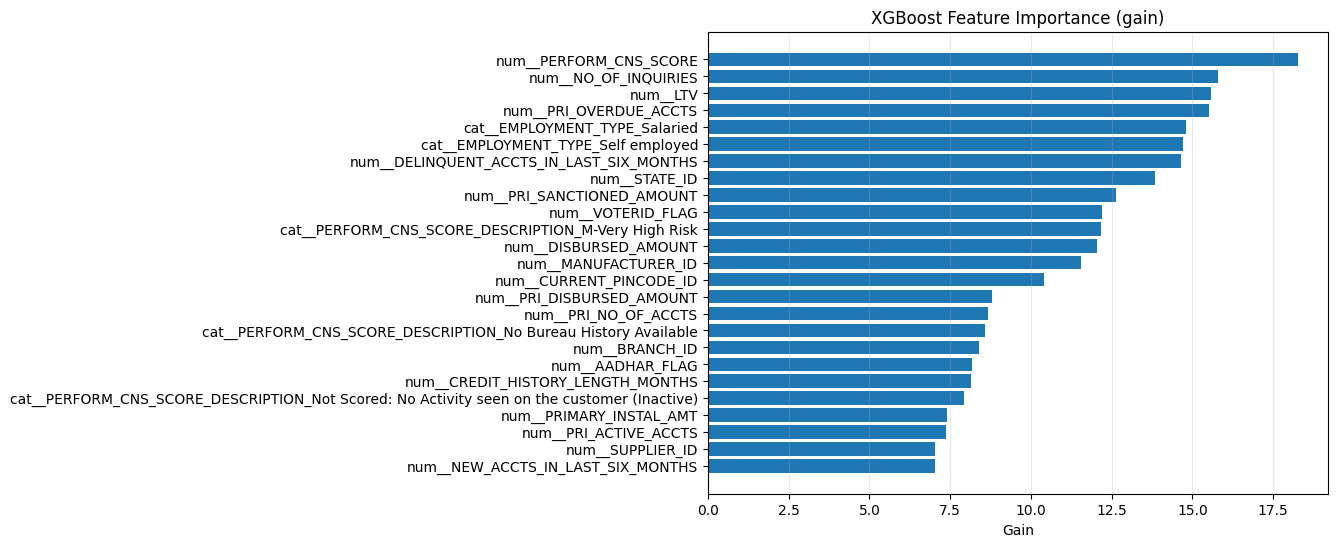

In [16]:
importance_dict = bst.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame.from_dict(importance_dict, orient="index", columns=["gain"])
      .sort_values("gain", ascending=False)
)

top = imp_df.head(25)

plt.figure(figsize=(8,6))
plt.barh(top.index[::-1], top["gain"].values[::-1])
plt.title("XGBoost Feature Importance (gain)")
plt.xlabel("Gain")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

## 8) LightGBM

LightGBM uses histogram-based splits and leaf-wise tree growth, which can lead to faster training and improved performance on large feature spaces.

In [22]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

lgbm = LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[
        early_stopping(stopping_rounds=200),
        log_evaluation(period=200),
    ],
)

p_val = lgbm.predict_proba(X_val)[:, 1]
p_test = lgbm.predict_proba(X_test)[:, 1]
val_probs["LGBM"] = p_val
test_probs["LGBM"] = p_test

display(evaluate_binary(y_val, p_val, "lightgbm"))

out_path = os.path.join(RESULTS_DIR, "boosting_lgbm_test_preds.csv")
export_predictions(test_df[id_col], y_test, p_test, out_path)


[LightGBM] [Info] Number of positive: 35427, number of negative: 127780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4896
[LightGBM] [Info] Number of data points in the train set: 163207, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217068 -> initscore=-1.282836
[LightGBM] [Info] Start training from score -1.282836
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.495342
[400]	valid_0's binary_logloss: 0.494712
[600]	valid_0's binary_logloss: 0.494324
[800]	valid_0's binary_logloss: 0.494417
Early stopping, best iteration is:
[609]	valid_0's binary_logloss: 0.494302


{'model': 'lightgbm',
 'roc_auc': 0.663016803357408,
 'pr_auc': 0.34623340619684123,
 'log_loss': 0.4943020073092746}

Saved: ..\results\boosting_lgbm_test_preds.csv shape: (34974, 3)


,UNIQUEID,y_true,y_prob
0,490213,0,0.211317
1,492995,1,0.554029
2,586411,0,0.225780
3,519075,0,0.171749
4,525983,0,0.102936


In [19]:
lgbm_model_path = os.path.join(MODELS_DIR, "lgbm_model.txt")
lgbm.booster_.save_model(lgbm_model_path)

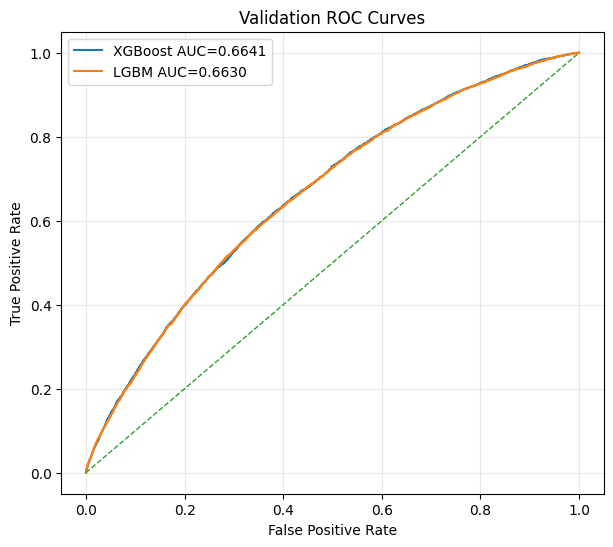

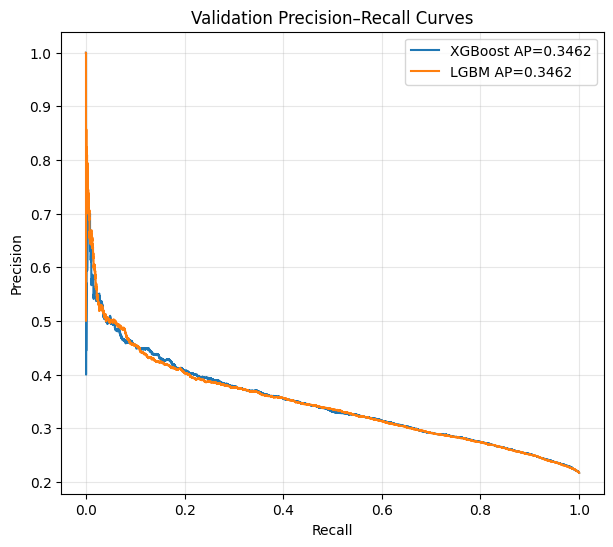

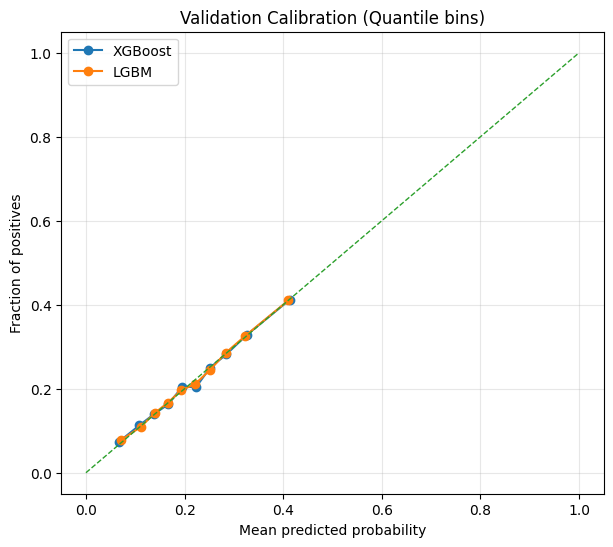

,brier_score
XGBoost,0.160043
LGBM,0.160128


In [20]:
plot_roc_pr(y_val, val_probs, title_prefix="Validation")
plot_calibration(y_val, val_probs, n_bins=10, title="Validation Calibration (Quantile bins)")

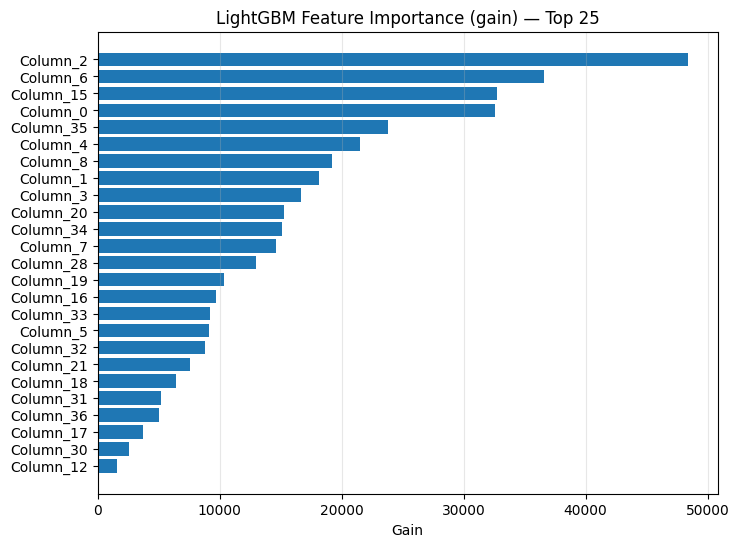

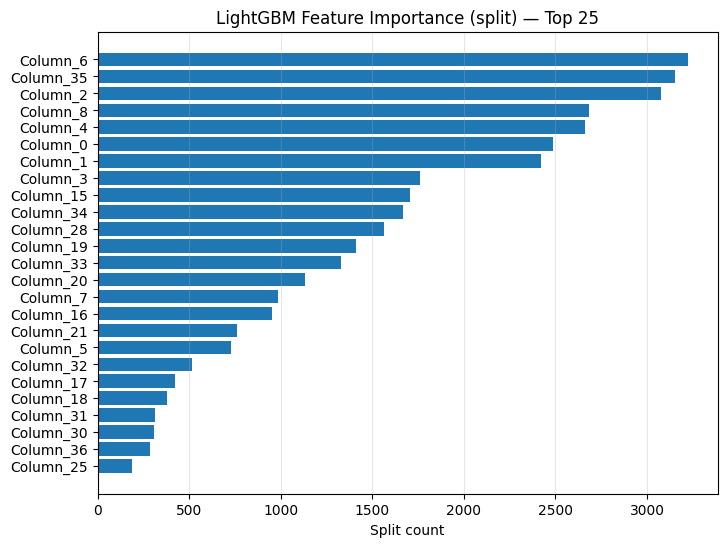

In [21]:
importances_split = lgbm.booster_.feature_importance(importance_type="split")
importances_gain  = lgbm.booster_.feature_importance(importance_type="gain")
feat_names = lgbm.booster_.feature_name()

imp_split = pd.DataFrame({"feature": feat_names, "split": importances_split}).sort_values("split", ascending=False)
imp_gain  = pd.DataFrame({"feature": feat_names, "gain":  importances_gain}).sort_values("gain",  ascending=False)

# Top 25 by gain
top = imp_gain.head(25)

plt.figure(figsize=(8,6))
plt.barh(top["feature"].values[::-1], top["gain"].values[::-1])
plt.title("LightGBM Feature Importance (gain) — Top 25")
plt.xlabel("Gain")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# Top 25 by split
top = imp_split.head(25)

plt.figure(figsize=(8,6))
plt.barh(top["feature"].values[::-1], top["split"].values[::-1])
plt.title("LightGBM Feature Importance (split) — Top 25")
plt.xlabel("Split count")
plt.grid(True, axis="x", alpha=0.3)
plt.show()


## 9) CatBoost

CatBoost is designed to handle categorical features effectively and reduce target leakage through ordered boosting, making it robust in financial datasets.

In [27]:
from catboost import CatBoostClassifier

cat_feature_indices = [X_train_raw.columns.get_loc(c) for c in cat_cols]
# Make safe copies
X_train_raw = X_train_raw.copy()
X_val_raw   = X_val_raw.copy()

# Ensure cat cols are strings and have no NaNs
for c in cat_cols:
    X_train_raw[c] = X_train_raw[c].astype("object").where(X_train_raw[c].notna(), "__MISSING__").astype(str)
    X_val_raw[c]   = X_val_raw[c].astype("object").where(X_val_raw[c].notna(), "__MISSING__").astype(str)

# Recompute indices in case column order changed (usually not needed, but safe)
cat_feature_indices = [X_train_raw.columns.get_loc(c) for c in cat_cols]

In [29]:
cat = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
)

cat.fit(
    X_train_raw, y_train,
    eval_set=(X_val_raw, y_val),
    cat_features=cat_feature_indices,
    use_best_model=True,
)

0:	test: 0.5724572	best: 0.5724572 (0)	total: 214ms	remaining: 10m 40s
200:	test: 0.6538634	best: 0.6538634 (200)	total: 1m 2s	remaining: 14m 30s
400:	test: 0.6583321	best: 0.6583321 (400)	total: 1m 55s	remaining: 12m 30s
600:	test: 0.6613448	best: 0.6613448 (600)	total: 2m 55s	remaining: 11m 40s
800:	test: 0.6625917	best: 0.6626231 (798)	total: 3m 52s	remaining: 10m 38s
1000:	test: 0.6633520	best: 0.6634246 (981)	total: 4m 44s	remaining: 9m 28s
1200:	test: 0.6635087	best: 0.6635699 (1136)	total: 5m 37s	remaining: 8m 25s
1400:	test: 0.6633991	best: 0.6635699 (1136)	total: 6m 31s	remaining: 7m 26s
1600:	test: 0.6634155	best: 0.6635699 (1136)	total: 7m 31s	remaining: 6m 34s
1800:	test: 0.6631290	best: 0.6635699 (1136)	total: 8m 23s	remaining: 5m 35s
2000:	test: 0.6629910	best: 0.6635699 (1136)	total: 9m 18s	remaining: 4m 38s
2200:	test: 0.6630193	best: 0.6635699 (1136)	total: 10m 9s	remaining: 3m 41s
2400:	test: 0.6628703	best: 0.6635699 (1136)	total: 11m	remaining: 2m 44s
2600:	test: 0.

In [30]:
X_test_raw = X_test_raw.copy()
for c in cat_cols:
    X_test_raw[c] = X_test_raw[c].astype("object").where(X_test_raw[c].notna(), "__MISSING__").astype(str)

p_val  = cat.predict_proba(X_val_raw)[:, 1]
p_test = cat.predict_proba(X_test_raw)[:, 1]
val_probs["CATBoost"] = p_val
test_probs["CATBoost"] = p_test

display(evaluate_binary(y_val, p_val, "catboost"))

out_path = os.path.join(RESULTS_DIR, "boosting_cat_test_preds.csv")

export_predictions(
    unique_ids=test_df[id_col],
    y_true=y_test,
    y_prob=p_test,
    out_path=out_path,
)

model_path = os.path.join(MODELS_DIR, "catboost_model.cbm")
cat.save_model(model_path)

{'model': 'catboost',
 'roc_auc': 0.6635698503407926,
 'pr_auc': 0.3479506699903436,
 'log_loss': 0.4940056441962511}

Saved: ..\results\boosting_cat_test_preds.csv shape: (34974, 3)


,UNIQUEID,y_true,y_prob
0,490213,0,0.302292
1,492995,1,0.602079
2,586411,0,0.249987
3,519075,0,0.189802
4,525983,0,0.109797


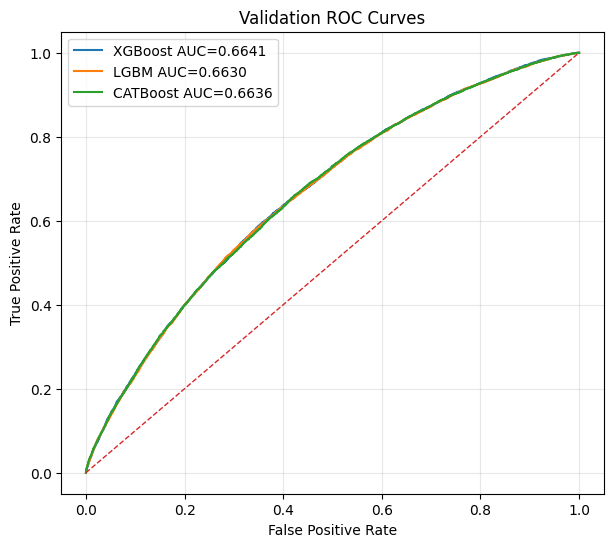

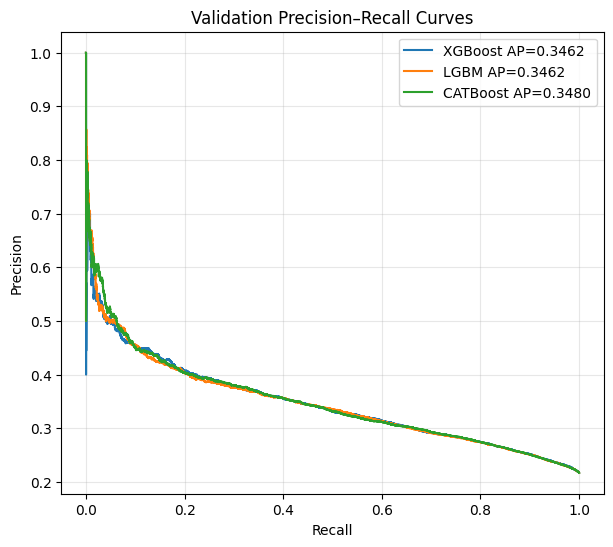

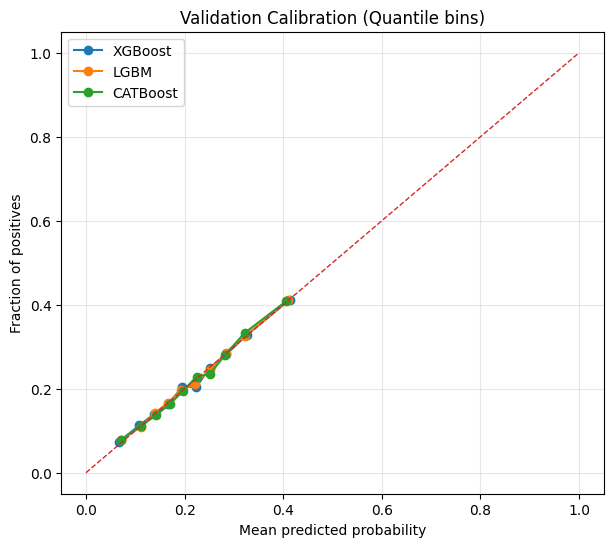

,brier_score
CATBoost,0.160019
XGBoost,0.160043
LGBM,0.160128


In [31]:
plot_roc_pr(y_val, val_probs, title_prefix="Validation")
plot_calibration(y_val, val_probs, n_bins=10, title="Validation Calibration (Quantile bins)")

## 10) Compare

Model performance is evaluated on the held-out test set using the same metrics for all approaches. This allows for a fair comparison of predictive accuracy and generalization.

In [32]:
rows = []
for name, p in val_probs.items():
    rows.append(evaluate_binary(y_val, p, name))
summary = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
summary


,model,roc_auc,pr_auc,log_loss
0,XGBoost,0.664073,0.346198,0.493931
2,CATBoost,0.663570,0.347951,0.494006
1,LGBM,0.663017,0.346233,0.494302


On the test set, all boosting models show strong and consistent performance, indicating good generalization. XGBoost achieves the highest AUC, making it the best-performing model overall for this task.

LightGBM and CatBoost perform competitively, but the differences are relatively small, suggesting diminishing returns from model choice alone. Further improvements are likely to come from feature refinement or decision threshold optimization rather than changing the algorithm.